In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Feature extraction

In [2]:
import glob
import os
import numpy as np

from PIL import Image, ImageFile
from omegaconf import OmegaConf

from config.init import create_baseconfig_from_checkpoint
from model.lgffem import LGFFEM

from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

# from tqdm import tqdm

# import umap

# import matplotlib.pyplot as plt
# import seaborn as sns

# %matplotlib inline
# sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

In [3]:
import torch
from torchvision.transforms import v2

from torchinfo import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Create model from checkpoint

In [4]:
path_checkpoint = os.path.join('/thesis/checkpoint/BASE/BASE-EMB-KIMIA-11_convnextv2-02_neck_512_3-00_head_A-epoch499.pth')
checkpoint = torch.load(path_checkpoint)

In [5]:
base_config = create_baseconfig_from_checkpoint(checkpoint)

embedder = LGFFEM(base_config).eval()
match_n = embedder.neck.load_state_dict(checkpoint['model_neck_state_dict'], strict = False)
print('[++] Loaded neck weights.', match_n)
match_h = embedder.head.load_state_dict(checkpoint['model_head_state_dict'], strict = False)
print('[++] Loaded head weights.', match_h)

[++] Loaded neck weights. <All keys matched successfully>
[++] Loaded head weights. <All keys matched successfully>


In [6]:
img_transforms = v2.Compose([
                            v2.ToImage(),
                            v2.Resize(size=(224, 224)),
                            v2.ToDtype(torch.float32, scale=True),
                            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                          ])

## Get embeddings from Kimia Test imgs

In [7]:
import cv2
from PIL import Image

In [8]:
def get_image_from_path(path, transform=None):
    """A function that gets a URL of an image, 
    and returns a numpy image and a preprocessed
    torch tensor ready to pass to the model """

    img = np.array(Image.open(path))
    img = cv2.resize(img, (224, 224))
    rgb_img_float = np.float32(img) / 255
    
    if transform:
        input_tensor = transform(img)

    return img, rgb_img_float, input_tensor

In [9]:
query_img, query_img_float, query_tensor = get_image_from_path('/thesis/classical/test-patches-kimia/s0/s0_1.jpg',
                                                               img_transforms)

In [10]:
query_features = embedder(query_tensor.unsqueeze(0)).squeeze(0)

In [11]:
query_features.shape

torch.Size([2048])

In [23]:
s0_2_img, s0_2_img_float, s0_2_tensor = get_image_from_path('/thesis/classical/test-patches-kimia/s0/s0_2.jpg',
                                                               img_transforms)
s0_2_features = embedder(s0_2_tensor.unsqueeze(0)).squeeze(0)


s0_3_img, s0_3_img_float, s0_3_tensor = get_image_from_path('/thesis/classical/test-patches-kimia/s0/s0_3.jpg',
                                                               img_transforms)
s0_3_features = embedder(s0_3_tensor.unsqueeze(0)).squeeze(0)


s0_4_img, s0_4_img_float, s0_4_tensor = get_image_from_path('/thesis/classical/test-patches-kimia/s0/s0_4.jpg',
                                                               img_transforms)
s0_4_features = embedder(s0_4_tensor.unsqueeze(0)).squeeze(0)


s0_5_img, s0_5_img_float, s0_5_tensor = get_image_from_path('/thesis/classical/test-patches-kimia/s0/s0_5.jpg',
                                                               img_transforms)
s0_5_features = embedder(s0_5_tensor.unsqueeze(0)).squeeze(0)


s0_6_img, s0_6_img_float, s0_6_tensor = get_image_from_path('/thesis/classical/test-patches-kimia/s0/s0_6.jpg',
                                                               img_transforms)
s0_6_features = embedder(s0_6_tensor.unsqueeze(0)).squeeze(0)

## GradCAM Analyze 

In [13]:
class SimilarityToConceptTarget:
    def __init__(self, features):
        self.features = features
    
    def __call__(self, model_output):
        cos = torch.nn.CosineSimilarity(dim=0)
        return cos(model_output, self.features)

In [65]:
target_layers = [
                 embedder.neck.neck_layer_1.p12_gca_p10, embedder.neck.neck_layer_1.p12_lca_p21, 
                 embedder.neck.neck_layer_1.p22_lca_p20, embedder.neck.neck_layer_1.p22_lca_P21, embedder.neck.neck_layer_1.p22_gca_p12,
                 embedder.neck.neck_layer_1.p32_lca_p30, embedder.neck.neck_layer_1.p32_lca_P31, embedder.neck.neck_layer_1.p32_gca_p22,
                 embedder.neck.neck_layer_1.p42_lca_p40, embedder.neck.neck_layer_1.p42_gca_p32, 
                ]

query_targets = [SimilarityToConceptTarget(query_features)]

s0_2_targets = [SimilarityToConceptTarget(s0_2_features)]
s0_3_targets = [SimilarityToConceptTarget(s0_3_features)]
s0_4_targets = [SimilarityToConceptTarget(s0_4_features)]
s0_5_targets = [SimilarityToConceptTarget(s0_5_features)]
s0_6_targets = [SimilarityToConceptTarget(s0_6_features)]

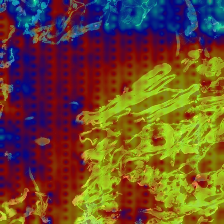

In [67]:
with GradCAMPlusPlus(model=embedder,
             target_layers=target_layers,
             ) as cam:
    grayscale_cam = cam(input_tensor=s0_2_tensor.unsqueeze(0),
                        targets=query_targets)[0, :]
    
cam_image = 1 - show_cam_on_image(s0_2_img_float, grayscale_cam, use_rgb=True)
Image.fromarray(cam_image)